# **Rede Neural**

In [5]:
import numpy as np

class RedeNeural:
    def __init__(self, estrutura):
        self.estrutura = estrutura
        self.pesos = []
        self.vies = []
        for i in range(len(estrutura) - 1):
            # Inicialização Xavier
            limite = np.sqrt(6 / (estrutura[i] + estrutura[i + 1]))
            self.pesos.append(np.random.uniform(-limite, limite, (estrutura[i], estrutura[i + 1])))
            self.vies.append(np.zeros((1, estrutura[i + 1])))



    def relu(self, z):

        return np.maximum(0, z)

    def derivada_relu(self, z):

        return (z > 0).astype(float)

    def erro_quadratico_medio(self, y_pred, y_true):

        return np.mean((y_pred - y_true) ** 2)

    def derivada_eqm(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_true.size

    def feedforward(self, entrada):
        ativacoes = [entrada]
        z_camadas = []

        for peso, vies in zip(self.pesos, self.vies):
            z = np.dot(ativacoes[-1], peso) + vies
            z_camadas.append(z)
            ativacao = self.relu(z)
            ativacoes.append(ativacao)

        return ativacoes, z_camadas

    def backpropagation(self, entrada, saida_real, taxa_aprendizado):

        # Passo 1: Feedforward
        ativacoes, z_camadas = self.feedforward(entrada)

        # Passo 2: Calcula erro da saída
        erro_saida = self.derivada_eqm(ativacoes[-1], saida_real) * self.derivada_relu(z_camadas[-1])

        deltas = [erro_saida]

        # Passo 3: Retropropagação do erro
        for i in range(len(self.estrutura) - 2, 0, -1):
            erro = np.dot(deltas[0], self.pesos[i].T) * self.derivada_relu(z_camadas[i - 1])
            deltas.insert(0, erro)

        # Passo 4: Atualização de pesos e vieses
        for i in range(len(self.pesos)):
            self.pesos[i] -= taxa_aprendizado * np.dot(ativacoes[i].T, deltas[i])
            self.vies[i] -= taxa_aprendizado * np.sum(deltas[i], axis=0, keepdims=True)

---
# **Regressão**
---

### Carregamento do Dataset - California Housing Prices

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

def carregar_dados_regressao():
    df = pd.read_csv('housing.csv')
    
    # TODO arrumar depois - ignorando ocean_proximity
    df = df.drop(columns=['ocean_proximity'])

    # entradas (X) e a saída (y)
    X = df.drop(columns=['median_house_value']).values
    y = df['median_house_value'].values.reshape(-1, 1)
    

    # normaliza os dados
    scaler_X = RobustScaler()
    scaler_y = RobustScaler()
    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y)

    X_treino, X_teste, y_treino, y_teste = train_test_split(
        X, y, test_size=0.2, random_state=42)

    return X_treino, X_teste, y_treino, y_teste, scaler_y

# configura os dados
X_treino, X_teste, y_treino, y_teste, scaler_y = carregar_dados_regressao()


### Treinamento

In [4]:
estrutura_camadas = [X_treino.shape[1], 50, 1]  # Camada oculta com 50 neurônios
rede = RedeNeural(estrutura_camadas)

# Treinamento a rede
def treinar_rede_regressao_ajustada(rede, X_treino, y_treino, X_teste, y_teste, epochs=2000, taxa_aprendizado=0.01):
    erros_treino = []
    erros_teste = []

    for epoca in range(epochs):
        # Treinar com o conjunto de treino
        rede.backpropagation(X_treino, y_treino, taxa_aprendizado)

        # Calcular erro no treino e no teste
        ativacoes_treino, _ = rede.feedforward(X_treino)
        erro_treino = rede.erro_quadratico_medio(ativacoes_treino[-1], y_treino)
        erros_treino.append(erro_treino)

        ativacoes_teste, _ = rede.feedforward(X_teste)
        erro_teste = rede.erro_quadratico_medio(ativacoes_teste[-1], y_teste)
        erros_teste.append(erro_teste)

        # Exibir progresso a cada 100 épocas
        if epoca % 100 == 0:
            print(f"Época {epoca}: Erro de Treino = {erro_treino:.4f}, Erro de Teste = {erro_teste:.4f}")

    return erros_treino, erros_teste


# Executar o treinamento
erros_treino, erros_teste = treinar_rede_regressao_ajustada(rede, X_treino, y_treino, X_teste, y_teste)


Época 0: Erro de Treino = 0.6377, Erro de Teste = nan
Época 100: Erro de Treino = 0.3434, Erro de Teste = nan
Época 200: Erro de Treino = 0.3161, Erro de Teste = nan
Época 300: Erro de Treino = 0.3089, Erro de Teste = nan
Época 400: Erro de Treino = 0.3050, Erro de Teste = nan
Época 500: Erro de Treino = 0.3020, Erro de Teste = nan
Época 600: Erro de Treino = 0.2997, Erro de Teste = nan
Época 700: Erro de Treino = 0.2976, Erro de Teste = nan
Época 800: Erro de Treino = 0.2958, Erro de Teste = nan
Época 900: Erro de Treino = 0.2941, Erro de Teste = nan
Época 1000: Erro de Treino = 0.2924, Erro de Teste = nan
Época 1100: Erro de Treino = 0.2909, Erro de Teste = nan
Época 1200: Erro de Treino = 0.2895, Erro de Teste = nan
Época 1300: Erro de Treino = 0.2882, Erro de Teste = nan
Época 1400: Erro de Treino = 0.2869, Erro de Teste = nan
Época 1500: Erro de Treino = 0.2857, Erro de Teste = nan
Época 1600: Erro de Treino = 0.2846, Erro de Teste = nan
Época 1700: Erro de Treino = 0.2835, Erro d

### Visualização dos Resultados

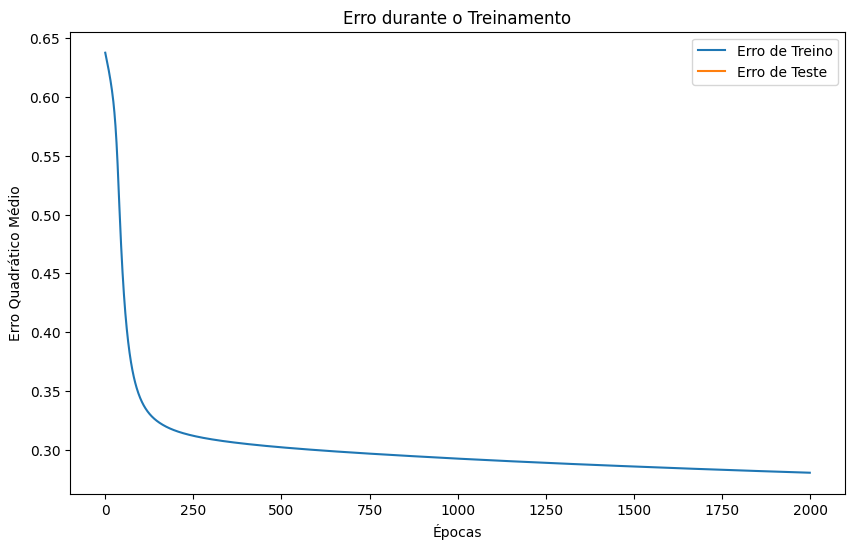

In [5]:
import matplotlib.pyplot as plt

# Plotar erros de treino e teste
plt.figure(figsize=(10, 6))
plt.plot(erros_treino, label="Erro de Treino")
plt.plot(erros_teste, label="Erro de Teste")
plt.xlabel("Épocas")
plt.ylabel("Erro Quadrático Médio")
plt.title("Erro durante o Treinamento")
plt.legend()
plt.show()

---
# **Classificação Binária**
---

### Carregamento do Dataset - PIMA Indians Diabetes Dataset

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

df = pd.read_csv('diabetes.csv')

X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Treinamento

In [8]:
class RedeNeuralClassificacao(RedeNeural):
    def __init__(self, estrutura):
        super().__init__(estrutura)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def derivada_sigmoid(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def feedforward(self, entrada):
        ativacoes = [entrada]
        z_camadas = []

        for peso, vies in zip(self.pesos, self.vies):
            z = np.dot(ativacoes[-1], peso) + vies
            z_camadas.append(z)
            ativacao = self.sigmoid(z)
            ativacoes.append(ativacao)

        return ativacoes, z_camadas

    def backpropagation(self, entrada, saida_real, taxa_aprendizado):
        ativacoes, z_camadas = self.feedforward(entrada)
        erro_saida = (ativacoes[-1] - saida_real) * self.derivada_sigmoid(z_camadas[-1])

        deltas = [erro_saida]

        for i in range(len(self.estrutura) - 2, 0, -1):
            erro = np.dot(deltas[0], self.pesos[i].T) * self.derivada_sigmoid(z_camadas[i-1])
            deltas.insert(0, erro)

        for i in range(len(self.pesos)):
            self.pesos[i] -= taxa_aprendizado * np.dot(ativacoes[i].T, deltas[i])
            self.vies[i] -= taxa_aprendizado * np.sum(deltas[i], axis=0, keepdims=True)
            

# configura
estrutura_camadas = [X_train.shape[1], 64, 1]  # camada oculta - 64 neurônios
rede_classificacao = RedeNeuralClassificacao(estrutura_camadas)


# treina
def treinar_rede_classificacao(rede, X_train, y_train, X_test, y_test, epochs=1000, taxa_aprendizado=0.01):
    for epoch in range(epochs):
        rede.backpropagation(X_train, y_train.values.reshape(-1,1), taxa_aprendizado)
        if epoch % 100 == 0:
            # calcula as previsões para treino e teste
            y_pred_train = rede.feedforward(X_train)[0][-1]
            y_pred_test = rede.feedforward(X_test)[0][-1]

            # calcula o erro
            erro_treino = rede.erro_quadratico_medio(y_pred_train, y_train.values.reshape(-1,1))
            erro_teste = rede.erro_quadratico_medio(y_pred_test, y_test.values.reshape(-1,1))

            print(f"Época {epoch}: Erro de treino = {erro_treino:.4f} - Erro de teste = {erro_teste:.4f}")

# Executa
treinar_rede_classificacao(rede_classificacao, X_train, y_train, X_test, y_test)

Época 0: Erro de treino = 0.2629 - Erro de teste = 0.2701
Época 100: Erro de treino = 0.1600 - Erro de teste = 0.1866
Época 200: Erro de treino = 0.1565 - Erro de teste = 0.1840
Época 300: Erro de treino = 0.1528 - Erro de teste = 0.1833
Época 400: Erro de treino = 0.1482 - Erro de teste = 0.1827
Época 500: Erro de treino = 0.1445 - Erro de teste = 0.1816
Época 600: Erro de treino = 0.1419 - Erro de teste = 0.1804
Época 700: Erro de treino = 0.1398 - Erro de teste = 0.1799
Época 800: Erro de treino = 0.1378 - Erro de teste = 0.1804
Época 900: Erro de treino = 0.1354 - Erro de teste = 0.1818


### Visualização dos Resultados

---
# **Classificação Multiclasse**
---

### Carregamento do Dataset - Iris

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

df = pd.read_csv('iris.csv')

X = df.drop(columns=["Id", "Species"])
y = df["Species"]

encoder = OneHotEncoder()
y = encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Treinamento

In [2]:
class RedeNeuralMulticlasse:
    def __init__(self, estrutura):
        self.estrutura = estrutura
        self.pesos = []
        self.vies = []
        for i in range(len(estrutura) - 1):
            limite = np.sqrt(6 / (estrutura[i] + estrutura[i + 1]))
            self.pesos.append(np.random.uniform(-limite, limite, (estrutura[i], estrutura[i + 1])))
            self.vies.append(np.zeros((1, estrutura[i + 1])))

    def relu(self, z):
        return np.maximum(0, z)

    def derivada_relu(self, z):
        return (z > 0).astype(float)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true):
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))

    def feedforward(self, entrada):
        ativacoes = [entrada]
        z_camadas = []

        for peso, vies in zip(self.pesos, self.vies):
            z = np.dot(ativacoes[-1], peso) + vies
            z_camadas.append(z)
            if len(z_camadas) == len(self.pesos):
                ativacao = self.softmax(z)
            else:
                ativacao = self.relu(z)
            ativacoes.append(ativacao)

        return ativacoes, z_camadas

    def backpropagation(self, entrada, saida_real, taxa_aprendizado):
        ativacoes, z_camadas = self.feedforward(entrada)

        erro_saida = ativacoes[-1] - saida_real
        deltas = [erro_saida]

        for i in range(len(self.estrutura) - 2, 0, -1):
            erro = np.dot(deltas[0], self.pesos[i].T) * self.derivada_relu(z_camadas[i - 1])
            deltas.insert(0, erro)

        for i in range(len(self.pesos)):
            gradiente_peso = np.dot(ativacoes[i].T, deltas[i])
            gradiente_vies = np.sum(deltas[i], axis=0, keepdims=True)

            self.pesos[i] -= taxa_aprendizado * gradiente_peso
            self.vies[i] -= taxa_aprendizado * gradiente_vies

In [3]:
# configura a rede
estrutura_camadas = [X_train.shape[1], 120, y_train.shape[1]]
rede_multiclasse = RedeNeuralMulticlasse(estrutura_camadas)

def treinar_rede_multiclasse(rede, X_train, y_train, X_test, y_test, epochs=2000, taxa_aprendizado=0.01):
    erros_treino = []
    erros_teste = []


    X_train = np.asarray(X_train)
    y_train = y_train.toarray() if hasattr(y_train, "toarray") else np.asarray(y_train)
    X_test = np.asarray(X_test)
    y_test = y_test.toarray() if hasattr(y_test, "toarray") else np.asarray(y_test)

    for epoch in range(epochs):
        rede.backpropagation(X_train, y_train, taxa_aprendizado)

        y_pred_train = rede.feedforward(X_train)[0][-1]
        y_pred_test = rede.feedforward(X_test)[0][-1]

        erro_treino = rede.cross_entropy_loss(y_pred_train, y_train)
        erro_teste = rede.cross_entropy_loss(y_pred_test, y_test)

        erros_treino.append(erro_treino)
        erros_teste.append(erro_teste)

        if epoch % 100 == 0:
            print(f"Época {epoch}: Erro de treino = {erro_treino:.4f}, Erro de teste = {erro_teste:.4f}")

    return erros_treino, erros_teste


# treinamento da rede
erros_treino, erros_teste = treinar_rede_multiclasse(rede_multiclasse, X_train, y_train, X_test, y_test)



Época 0: Erro de treino = 0.4999, Erro de teste = 0.4309
Época 100: Erro de treino = 0.0504, Erro de teste = 0.0286
Época 200: Erro de treino = 0.0444, Erro de teste = 0.0181
Época 300: Erro de treino = 0.0419, Erro de teste = 0.0148
Época 400: Erro de treino = 0.0397, Erro de teste = 0.0132
Época 500: Erro de treino = 0.0370, Erro de teste = 0.0127
Época 600: Erro de treino = 0.0344, Erro de teste = 0.0142
Época 700: Erro de treino = 0.0308, Erro de teste = 0.0156
Época 800: Erro de treino = 0.0274, Erro de teste = 0.0195
Época 900: Erro de treino = 0.0225, Erro de teste = 0.0241
Época 1000: Erro de treino = 0.0174, Erro de teste = 0.0281
Época 1100: Erro de treino = 0.0135, Erro de teste = 0.0328
Época 1200: Erro de treino = 0.0107, Erro de teste = 0.0426
Época 1300: Erro de treino = 0.0087, Erro de teste = 0.0491
Época 1400: Erro de treino = 0.0072, Erro de teste = 0.0601
Época 1500: Erro de treino = 0.0060, Erro de teste = 0.0694
Época 1600: Erro de treino = 0.0051, Erro de teste =

### Visualização dos Resultados

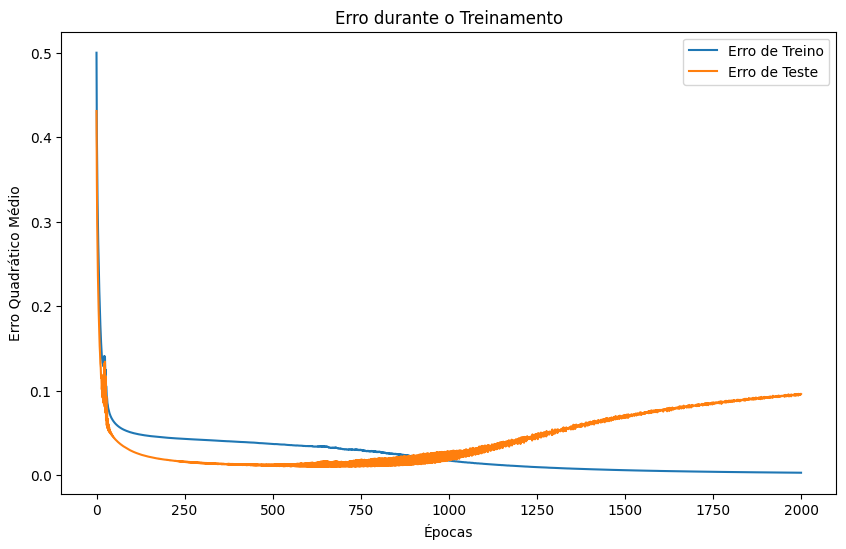

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(erros_treino, label="Erro de Treino")
plt.plot(erros_teste, label="Erro de Teste")
plt.xlabel("Épocas")
plt.ylabel("Erro Quadrático Médio")
plt.title("Erro durante o Treinamento")
plt.legend()
plt.show()